In [ ]:
pip install tensorflow

In [ ]:
pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 9.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, SimpleRNN, Dense, Masking

In [ ]:
cleaned_text_final_df=pd.read_csv('cleaned_text_final_df_glove_200.csv')

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

MAX_WORDS = 25  # Maximum words per sentence
EMBEDDING_DIM = 200  # Embedding dimension for each word (from 0 to 99)

def extract_word_vectors(row):
    vectors = []
    for i in range(MAX_WORDS):
        # Extract the embedding for each word (columns like word_0_dim_0 to word_0_dim_99)
        word_vector = row[f'word{i+1}_vec0':f'word{i+1}_vec99'].values
        vectors.append(word_vector)  # Append word vector for this word
    return np.array(vectors, dtype=np.float32)  # Ensure it's float32

X = cleaned_text_final_df.apply(extract_word_vectors, axis=1)
X = np.array(X.tolist(), dtype=np.float32)

# Extract labels
y = cleaned_text_final_df['class'].values

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}, Validation set size: {X_val.shape}")


Training set size: (298, 25, 100), Validation set size: (75, 25, 100)


In [ ]:
from tensorflow.keras.regularizers import l2

def build_model(model_type='LSTM'):
    model = Sequential()

    model.add(Masking(mask_value=0.0, input_shape=(MAX_WORDS, EMBEDDING_DIM)))

    # Add L2 regularization to recurrent layers
    if model_type == 'LSTM':
        model.add(LSTM(64, dropout=0.3, recurrent_dropout=0.2,
                       return_sequences=False, kernel_regularizer=l2(0.01)))
    elif model_type == 'GRU':
        model.add(GRU(64, dropout=0.3, recurrent_dropout=0.2,
                      return_sequences=False, kernel_regularizer=l2(0.01)))
    else:  # Simple RNN
        model.add(SimpleRNN(64, dropout=0.3, return_sequences=False,
                            kernel_regularizer=l2(0.01)))


    model.add(Dense(3, activation='softmax'))  # 3 output classes
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    return model


In [ ]:
"""
e=10 batch=50 L2 regularization
RNN Train Accuracy: 80.06%
RNN Test Accuracy: 80.06%

GRU Train Accuracy: 87.75%
GRU Test Accuracy: 87.14%

LSTM Train Accuracy: 87.28%
LSTM Test Accuracy: 87.57%

"""
"""
e=20 batch=45 L2 regularization
RNN Train Accuracy: 77.49%
RNN Test Accuracy: 78.06%

GRU Train Accuracy: 88.05%
GRU Test Accuracy: 88.02%

LSTM Train Accuracy: 87.27%
LSTM Test Accuracy: 87.32%

"""

In [ ]:
def train_and_evaluate(model_type):
    model = build_model(model_type)

    # Fit the model
    history = model.fit(
        X_train, y_train,
        epochs=20, batch_size=45,
        validation_data=(X_val, y_val)
    )

    # Evaluate the model
    loss, accuracy = model.evaluate(X_val, y_val)
    loss2, accuracy2 = model.evaluate(X_train, y_train)

    # Print the accuracy for both training and validation
    print(f"{model_type} Train Accuracy: {accuracy2 * 100:.2f}%")
    print(f"{model_type} Test Accuracy: {accuracy * 100:.2f}%")

    return history

history_RNN = train_and_evaluate("RNN")
history_GRU = train_and_evaluate("GRU")
history_LSTM = train_and_evaluate("LSTM")


Epoch 1/20
353/353 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.7885 - loss: 0.8306 - val_accuracy: 0.8475 - val_loss: 0.5396
Epoch 2/20
353/353 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.8158 - loss: 0.6384 - val_accuracy: 0.8293 - val_loss: 0.6347
Epoch 3/20
353/353 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.8088 - loss: 0.7423 - val_accuracy: 0.7796 - val_loss: 1.3854
Epoch 4/20
353/353 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8235 - loss: 1.0050 - val_accuracy: 0.8608 - val_loss: 0.5527
Epoch 5/20
353/353 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8346 - loss: 0.5631 - val_accuracy: 0.8023 - val_loss: 0.6317
Epoch 6/20
353/353 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.8040 - loss: 0.7521 - val_accuracy: 0.8265 - val_loss: 0.6346
Epoch 7/20
353/353 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7974 - loss: 0.6583 - val_accuracy: 0.8026 - val_loss: 0.6272
Epoch 8/20
353/353 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.7794 - loss: 0.6488 - val_acc

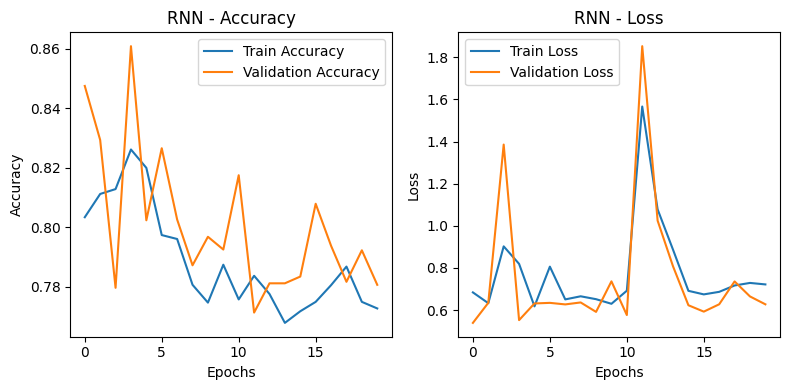

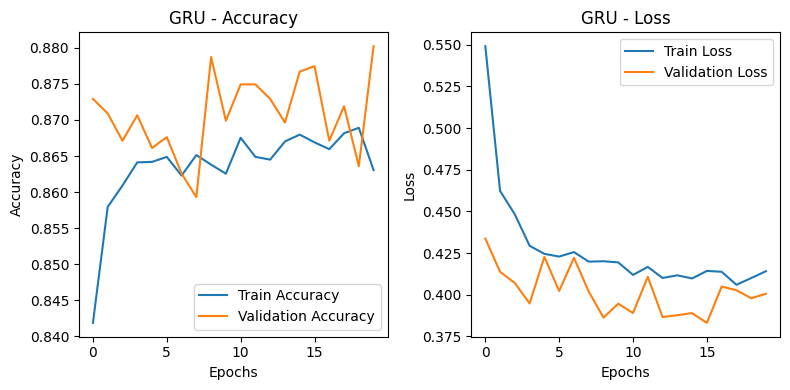

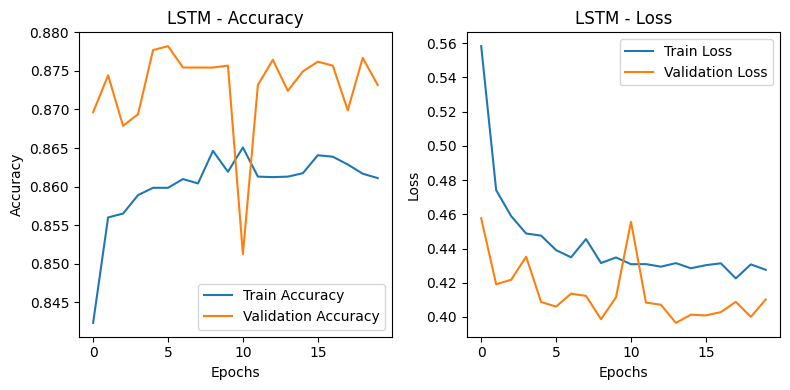

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history, model_name):
    # Plot training & validation accuracy values
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)  # Subplot for Accuracy
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)  # Subplot for Loss
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()

# Plot the history for each model
plot_history(history_RNN, 'RNN')
plot_history(history_GRU, 'GRU')
plot_history(history_LSTM, 'LSTM')
